In [1]:


import numpy as np
import pandas as pd
import csv
import sklearn
from sklearn.decomposition import TruncatedSVD as TSVD
from surprise import Reader, Dataset, SVDpp, SlopeOne, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, \
    KNNWithZScore, BaselineOnly, CoClustering, accuracy, SVD, NMF
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

columns = ['id','task','TaskId','rating']
frame = pd.read_csv('DataRecommenderSystem/DataDeliveryVisitor.csv',sep=',', names=columns)
frame.head()

,id,task,TaskId,rating
0,0,1000,1,7
1,1,1010,2,8
2,2,101010,3,7
3,3,100010,4,5
4,4,1000,5,6


In [2]:
columns2 =['TaskId','TaskName','Task']
tasks = pd.read_csv('DataRecommenderSystem/TaskDeliveryVisitor.csv', sep=',', names = columns2, encoding='latin-1')
task_names = tasks[['TaskId','TaskName','Task']]
task_names.head()


,TaskId,TaskName,Task
0,1,Task1,1000
1,2,Task2,1010
2,3,Task3,101010
3,4,Task4,100010
4,5,Task5,1000


In [3]:
combined_task_data = pd.merge(frame, task_names, on='TaskId')
combined_task_data.head()

,id,task,TaskId,rating,TaskName,Task
0,0,1000,1,7,Task1,1000
1,10,1000,1,9,Task1,1000
2,11,1000,1,5,Task1,1000
3,13,1000,1,4,Task1,1000
4,14,1000,1,9,Task1,1000


In [4]:
combined_task_data.groupby('TaskId')['rating'].count().sort_values(ascending=True).head()

filter_interview = combined_task_data['TaskId']==0
combined_task_data[filter_interview]['TaskName'].unique()

array([], dtype=object)

In [5]:
rating_crosstab = combined_task_data.pivot_table(values='rating', index='id', columns=['TaskName','Task'], fill_value=0.01)
rating_crosstab

TaskName,Task1,Task2,Task3,Task4,Task5,Task6,Task7,Task8
Task,1000,1010,101010,100010,1000,100000,1100,1111110
id,,,,,,,,
0,7.00,0.01,0.01,0.01,0.01,0.01,0.01,0.01
1,0.01,8.00,0.01,0.01,0.01,0.01,0.01,0.01
2,0.01,0.01,7.00,0.01,0.01,0.01,0.01,0.01
3,0.01,0.01,0.01,5.00,0.01,0.01,0.01,0.01
4,0.01,0.01,0.01,0.01,6.00,0.01,0.01,0.01
...,...,...,...,...,...,...,...,...
995,0.01,0.01,0.01,4.00,0.01,0.01,0.01,0.01
996,0.01,8.00,0.01,0.01,0.01,0.01,0.01,0.01


In [22]:
rating_crosstab.shape
X = rating_crosstab.T
X.shape

(8, 1000)

In [23]:
# trucated_SVD = TSVD(n_components=8)

# resultant_matrix = trucated_SVD.fit_transform(X)

# resultant_matrix.shape

In [24]:
# corr_mat = np.corrcoef(resultant_matrix)
# corr_mat.shape
# task_names = rating_crosstab.columns
# task_list = list(task_names)
# task_list
# task = task_list.index(('Task1',1000))
# task
# corr_1 = corr_mat[task]
# corr_1.shape
# corr_1

In [25]:
# with open('DataRecommenderSystem/recommenderSystemDelivery.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(corr_1)
#     writer.writerow(list(task_names[(corr_1<=1) & (corr_1 > -0.135)]))


In [26]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
#add
data = frame['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / frame.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} Delivery Task-ratings'.format(frame.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)
#add

In [27]:
#add
# Create trace
trace = go.Histogram(x = combined_task_data.TaskId,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 1000,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Delivery Task',
                   xaxis = dict(title = 'Number of Ratings Per Task'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.1)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)
#add

#add
# Create trace
trace = go.Histogram(x = combined_task_data.id,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 1000,
                                  size = 100))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Delivery Ratings Per User',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.1)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)
#add

In [28]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(combined_task_data[['id', 'TaskId', 'rating']], reader)

In [29]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    print(algorithm)
    results = cross_validate(algorithm, data, cv=5, verbose=False)

    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

smt = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   
print(smt)
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, cv=5, verbose=False)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Don

{'test_rmse': array([3.07013827, 3.1089063 , 3.18094642, 3.22782504, 3.09747632]),
 'test_mae': array([2.63293418, 2.61996201, 2.72456086, 2.79413145, 2.66451626]),
 'fit_time': (0.001989126205444336,
  0.0030014514923095703,
  0.004000186920166016,
  0.002000570297241211,
  0.003985166549682617),
 'test_time': (0.0020089149475097656,
  0.001996278762817383,
  0.0009899139404296875,
  0.0019996166229248047,
  0.002013683319091797)}

In [30]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)



Estimating biases using als...
RMSE: 2.9814


2.9813632412471085

In [31]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0

def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0

df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]
print(best_predictions)
print(worst_predictions)

     uid  iid  rui       est                    details  Iu   Ui       err
185  337    3  5.0  4.944539  {'was_impossible': False}   0  151  0.055461
175  685    3  5.0  4.944539  {'was_impossible': False}   0  151  0.055461
184  171    3  5.0  4.944539  {'was_impossible': False}   0  151  0.055461
177  618    6  5.0  5.120668  {'was_impossible': False}   0   47  0.120668
157  550    7  5.0  5.172121  {'was_impossible': False}   0   72  0.172121
2    584    7  5.0  5.172121  {'was_impossible': False}   0   72  0.172121
28   122    4  5.0  4.822205  {'was_impossible': False}   0   49  0.177795
6    949    4  5.0  4.822205  {'was_impossible': False}   0   49  0.177795
43   803    4  5.0  4.822205  {'was_impossible': False}   0   49  0.177795
104  920    1  5.0  4.812618  {'was_impossible': False}   0  233  0.187382
     uid  iid   rui       est                    details  Iu   Ui       err
33   447    1  10.0  4.812618  {'was_impossible': False}   0  233  5.187382
34    44    1  10.0  4.

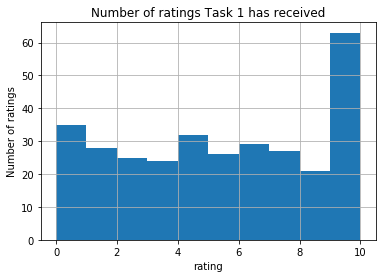

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
combined_task_data.loc[combined_task_data['TaskId'] == 1]['rating'].hist()
#fig = plt.figure()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings Task 1 has received')
plt.show();


Algorithm	 RMSE		 MAE

KNN Basic 	 3.1288 	 2.686
KNN Means 	 3.1314 	 2.6868
KNN ZScore 	 3.1304 	 2.6865
KNN Baseline 	 3.1295 	 2.6806

SVD 		 3.1317 	 2.6844
SVDpp 		 3.1283 	 2.6862

SlopeOne 	 3.1315 	 2.6869
CoClustering 	 3.1299 	 2.6861

NormalPred 	 4.1716 	 3.4502



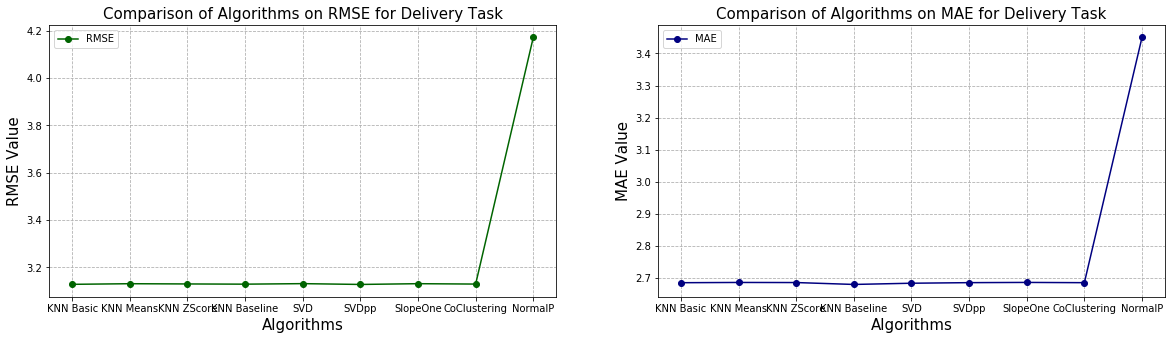

,id,task,TaskId,rating
count,1000.000000,1.000000e+03,1000.000000,1000.000000
mean,499.500000,8.937980e+04,3.220000,5.079000
std,288.819436,2.390314e+05,2.253148,3.131544
min,0.000000,1.000000e+03,1.000000,0.000000
25%,249.750000,1.000000e+03,1.000000,2.000000
50%,499.500000,1.010000e+03,3.000000,5.000000
75%,749.250000,1.000100e+05,5.000000,8.000000
max,999.000000,1.111110e+06,8.000000,10.000000


In [33]:
# SVD(), SVDpp(), SlopeOne(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()
knnbasic_cv = cross_validate(KNNBasic(), data, cv=5, n_jobs=5, verbose=False)
knnmeans_cv = cross_validate(KNNWithMeans(), data, cv=5, n_jobs=5, verbose=False)
knnz_cv = cross_validate(KNNWithZScore(), data, cv=5, n_jobs=5, verbose=False)
svd_cv = cross_validate(SVD(), data, cv=5, n_jobs=5, verbose=False)
svdpp_cv = cross_validate(SVDpp(), data, cv=5, n_jobs=5, verbose=False)
#nmf_cv = cross_validate(NMF(), data, cv=5, n_jobs=5, verbose=False)
slope_cv = cross_validate(SlopeOne(), data, cv=5, n_jobs=5, verbose=False)
coclus_cv = cross_validate(CoClustering(), data, cv=5, n_jobs=5, verbose=False)
normalPredictor_cv= cross_validate(NormalPredictor(),data, cv=5, n_jobs=5, verbose=False)
knnBaseline_cv = cross_validate(KNNBaseline(), data, cv=5, n_jobs=5, verbose=False)

print('Algorithm\t RMSE\t\t MAE')
print()
print('KNN Basic', '\t', round(knnbasic_cv['test_rmse'].mean(), 4), '\t', round(knnbasic_cv['test_mae'].mean(), 4))
print('KNN Means', '\t', round(knnmeans_cv['test_rmse'].mean(), 4), '\t', round(knnmeans_cv['test_mae'].mean(), 4))
print('KNN ZScore', '\t', round(knnz_cv['test_rmse'].mean(), 4), '\t', round(knnz_cv['test_mae'].mean(), 4))
print('KNN Baseline', '\t', round(knnBaseline_cv['test_rmse'].mean(), 4), '\t', round(knnBaseline_cv['test_mae'].mean(), 4))
print()
print('SVD', '\t\t', round(svd_cv['test_rmse'].mean(), 4), '\t', round(svd_cv['test_mae'].mean(), 4))
print('SVDpp', '\t\t', round(svdpp_cv['test_rmse'].mean(), 4), '\t', round(svdpp_cv['test_mae'].mean(), 4))
#print('NMF', '\t\t', round(nmf_cv['test_rmse'].mean(), 4), '\t', round(nmf_cv['test_mae'].mean(), 4))
print()
print('SlopeOne', '\t', round(slope_cv['test_rmse'].mean(), 4), '\t', round(slope_cv['test_mae'].mean(), 4))
print('CoClustering', '\t', round(coclus_cv['test_rmse'].mean(), 4), '\t', round(coclus_cv['test_mae'].mean(), 4))
print()
print('NormalPred', '\t', round(normalPredictor_cv['test_rmse'].mean(), 4), '\t', round(normalPredictor_cv['test_mae'].mean(), 4))
print()

x_algo = ['KNN Basic', 'KNN Means', 'KNN ZScore', 'KNN Baseline', 'SVD', 'SVDpp', 'SlopeOne', 'CoClustering', 'NormalP']
all_algos_cv = [knnbasic_cv, knnmeans_cv, knnz_cv, knnBaseline_cv, svd_cv, svdpp_cv, slope_cv, coclus_cv, normalPredictor_cv]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title('Comparison of Algorithms on RMSE for Delivery Task', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(1, 2, 2)
plt.title('Comparison of Algorithms on MAE for Delivery Task', loc='center', fontsize=15)
plt.plot(x_algo, mae_cv, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()
frame.describe()

In [34]:
# Parameter space
svd_param_grid = {'n_epochs': [20, 25], 
                  'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}

svdpp_gs = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse', 'mae'], cv=5)
svdpp_gs.fit(data)

svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5)
svd_gs.fit(data)

print('SVDpp - RMSE:', round(svdpp_gs.best_score['rmse'], 6), '; MAE:', round(svdpp_gs.best_score['mae'], 6))
print('SVD   - RMSE:', round(svd_gs.best_score['rmse'], 6), '; MAE:', round(svd_gs.best_score['mae'], 6))
#SVDpp best params
print('RMSE =', svdpp_gs.best_params['rmse'])
print('MAE =', svdpp_gs.best_params['mae'])
#SVD best params
print('RMSE =', svd_gs.best_params['rmse'])
print('MAE =', svd_gs.best_params['mae'])



SVDpp - RMSE: 3.133565 ; MAE: 2.690351
SVD   - RMSE: 3.12809 ; MAE: 2.691081
RMSE = {'n_epochs': 25, 'lr_all': 0.005, 'reg_all': 0.4}
MAE = {'n_epochs': 25, 'lr_all': 0.005, 'reg_all': 0.6}
RMSE = {'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.6}
MAE = {'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.6}


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

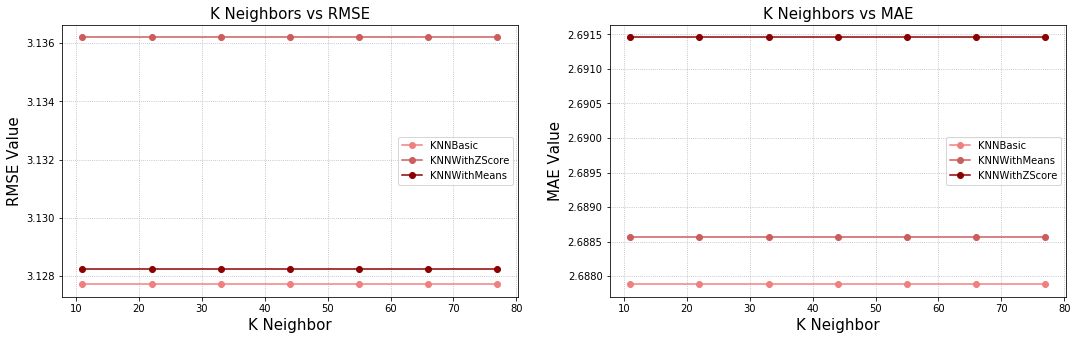

In [35]:
param_grid = {'k': [11, 22, 33, 44, 55, 66, 77]}

knnbasic_gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=5)
knnbasic_gs.fit(data)

knnmeans_gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=5)
knnmeans_gs.fit(data)

knnz_gs = GridSearchCV(KNNWithZScore, param_grid, measures=['rmse', 'mae'], cv=5)
knnz_gs.fit(data)

x = [11, 22, 33, 44, 55, 66, 77]
y1 = knnbasic_gs.cv_results['mean_test_rmse']
y2 = knnbasic_gs.cv_results['mean_test_mae']

y3 = knnmeans_gs.cv_results['mean_test_rmse']
y4 = knnmeans_gs.cv_results['mean_test_mae']

y5 = knnz_gs.cv_results['mean_test_rmse']
y6 = knnz_gs.cv_results['mean_test_mae']

plt.figure(figsize=(18,5))

plt.subplot(1, 2, 1)
plt.title('K Neighbors vs RMSE', loc='center', fontsize=15)
plt.plot(x, y1, label='KNNBasic', color='lightcoral', marker='o')
plt.plot(x, y5, label='KNNWithZScore', color='indianred', marker='o')
plt.plot(x, y3, label='KNNWithMeans', color='darkred', marker='o')

plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.subplot(1, 2, 2)
plt.title('K Neighbors vs MAE', loc='center', fontsize=15)
plt.plot(x, y2, label='KNNBasic', color='lightcoral', marker='o')
plt.plot(x, y4, label='KNNWithMeans', color='indianred', marker='o')
plt.plot(x, y6, label='KNNWithZScore', color='darkred', marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.show()

In [36]:
import surprise
from surprise import SVD
from surprise import Dataset
from surprise import accuracy


lower_rating = frame['rating'].min()
upper_rating = frame['rating'].max()

reader = surprise.Reader(rating_scale =(0,10))
#data = surprise.Dataset.load_from_df(frame,reader)

alg=surprise.SVDpp()
output=alg.fit(data.build_full_trainset())

pred = alg.predict(uid=0,iid=1)
score = pred.est
print(score)

iids = frame['TaskId'].unique()
iids0 = frame.loc[frame['id']==0,'TaskId']
print(iids0)
iids_to_pred = np.setdiff1d(iids,iids0)

testset = [[0,iid,3.] for iid in iids_to_pred]
predictions = alg.test(testset)

pred_ratings = np.array([pred.est for pred in predictions])
i_max = np.argpartition(pred_ratings, -3)[-3:]
print(i_max)
iid = iids_to_pred[i_max[0]]
iid2=iids_to_pred[i_max[1]]
iid3=iids_to_pred[i_max[2]]
print('Top item for user 50 has TaskId {0} with pred rating {1}'.format(iid,pred_ratings[i_max[0]]))
print('Top item for user 50 has TaskId {0} with pred rating {1}'.format(iid2,pred_ratings[i_max[1]]))
print('Top item for user 50 has TaskId {0} with pred rating {1}'.format(iid3,pred_ratings[i_max[2]]))

with open('DataRecommenderSystem/recommenderSystemDelivery.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(corr_1)
    writer.writerow(list([iid,iid2,iid3]))




6.829988818031544
0    1
Name: TaskId, dtype: int64
[6 5 0]
Top item for user 50 has TaskId 8 with pred rating 5.58963993896793
Top item for user 50 has TaskId 7 with pred rating 5.98975677686521
Top item for user 50 has TaskId 2 with pred rating 5.987207894812547
